# **Variables asociadas al diagnóstico de Demencia. Análisis exploratorio de datos con Python**

**Data:**
> **oasis_cross-sectional.csv**
>
> - Este conjunto de datos se obtuvo de consultar un determinado tiempo la sgte url: https://www.oasis-brains.org/#data 
> - Este dataset contiene datos de resonancia realizados en 416 sujetos, ademas se mencionan datos socidemograficos y tests cognitivos (MMSE y CDR)

**Link de descarga de los datos:**
> https://www.oasis-brains.org/files/oasis_cross-sectional.csv 

**Columnas en el dataset:**
        
        Genero --> Contiene el sexo biologico del sujeto (Femenino/Masculino)
        Lateralidad_Manual --> Contiene la dominancia manual del sujeto evaluado.
        Edad --> Contiene la edad en años del sujeto.
        Educacion--> Almacena el grado de instrucción. Clasificado entre las categorías: 1: secundaria incompleta, 2: secundaria completa, 3: universidad incompleta, 4: universidad completa ,5: post-bachiller
        NSE --> Contiene el nivel socioeconomico del sujeto. Clasificado entre las categorías de 1 (más alto status) to 5 ( más bajo status)
        MMSE --> Almacena el puntaje en el test MMSE, que mide la funcion cognitiva. Rangos de 0 (Peor) a 30 (Mejor), puntajes menores a 24 sugiere función anormal. 
        CDR --> Contiene el puntaje en el test CDR, que evalúa el grado de deterioro cognitivo. 0 : Sin demencia, 0.5 : Demencia muy leve, 1 : Demencia leve y 2 : Demencia moderada.
        eTIV --> Volumen intracraneal total estimado
        nWBV --> Volumen total del cerebro normalizado
        ASF --> Factor de escala Atlas (ASF) 
        Delay --> Almacena la cantidad de días entre las sesiones de MRI



**Carga de Librerías**

In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D
from warnings import filterwarnings 
filterwarnings('ignore')

**Obtención del dataset**

In [2]:
# Importar los datos
dementiaData = pd.read_csv("../input/oasis-crosssectional/oasis_cross-sectional.csv", sep = ",")

# Mejorando los nombres de las columnas 
dementiaData.columns = ["ID", "Genero", "Lateralidad_Manual", "Edad", "Educacion","NSE", "MMSE","CDR", "eTIV","nWBV", "ASF", "Delay"]
dementiaData

,ID,Genero,Lateralidad_Manual,Edad,Educacion,NSE,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
431,OAS1_0285_MR2,M,R,20,NaN,NaN,NaN,NaN,1469,0.847,1.195,2.0
432,OAS1_0353_MR2,M,R,22,NaN,NaN,NaN,NaN,1684,0.790,1.042,40.0
433,OAS1_0368_MR2,M,R,22,NaN,NaN,NaN,NaN,1580,0.856,1.111,89.0
434,OAS1_0379_MR2,F,R,20,NaN,NaN,NaN,NaN,1262,0.861,1.390,2.0


In [3]:
dementiaData.isnull().sum()

ID                      0
Genero                  0
Lateralidad_Manual      0
Edad                    0
Educacion             201
NSE                   220
MMSE                  201
CDR                   201
eTIV                    0
nWBV                    0
ASF                     0
Delay                 416
dtype: int64

## **Preprocesamiento de los datos**

**Eliminacion de columnas innecesarias**

In [4]:
dementiaData = dementiaData.drop(['Delay', 'ASF', 'eTIV'], axis = 1)
dementiaData.columns

Index(['ID', 'Genero', 'Lateralidad_Manual', 'Edad', 'Educacion', 'NSE',
       'MMSE', 'CDR', 'nWBV'],
      dtype='object')

Cantidad de filas y columnas

In [5]:
dementiaData.shape

(436, 9)

Hay una discordancia entre la cantidad de sujetos evaluados y la cantidad de filas, probablemente porque algunos sujetos se tomaron mas de una sesión de resonancia. 

**Eliminación de duplicados**

In [6]:
#Revisamos la estructura del ID en el dataset
dementiaData["ID"][0:5]

0    OAS1_0001_MR1
1    OAS1_0002_MR1
2    OAS1_0003_MR1
3    OAS1_0004_MR1
4    OAS1_0005_MR1
Name: ID, dtype: object

El ID en la data representa sesiones de resonancia, esta conformado por el identificador del sujeto "OAS1_xxxx" (por ejemplo, OAS1_0012) más el numero de sesión de imágen del sujeto, obteniendo el siguiente formato OAS1_xxxx_MRy, donde y representa el número de la visita de imágenes para el sujeto (por ejemplo, OAS1_0012_MR1). Para el proposito del estudio tendremos como unidad de análisis al sujeto, por lo que es necesario tener la data agrupado por el ID del sujeto, sin duplicados, para ello solo se incluirá las sesiones MR1 por sujeto.

In [7]:
#Obteniendo los IDs de los sujetos en el dataset
for i in range(0,len(dementiaData)):
  dementiaData["ID"][i] = dementiaData["ID"][i][0:9]
  #print(dementiaData["ID"][i])

In [8]:
#Observando cuales son los duplicados 
IDS = dementiaData["ID"]
duplicated_ID = dementiaData[IDS.isin(IDS[IDS.duplicated()])]
duplicated_ID

,ID,Genero,Lateralidad_Manual,Edad,Educacion,NSE,MMSE,CDR,nWBV
56,OAS1_0061,F,R,20,NaN,NaN,NaN,NaN,0.840
75,OAS1_0080,F,R,25,NaN,NaN,NaN,NaN,0.857
86,OAS1_0092,M,R,22,NaN,NaN,NaN,NaN,0.834
93,OAS1_0101,M,R,29,NaN,NaN,NaN,NaN,0.840
103,OAS1_0111,M,R,23,NaN,NaN,NaN,NaN,0.855
109,OAS1_0117,M,R,25,NaN,NaN,NaN,NaN,0.783
135,OAS1_0145,M,R,34,NaN,NaN,NaN,NaN,0.831
139,OAS1_0150,F,R,20,NaN,NaN,NaN,NaN,0.875
144,OAS1_0156,F,R,20,NaN,NaN,NaN,NaN,0.834
175,OAS1_0191,F,R,21,NaN,NaN,NaN,NaN,0.835


Se encontró que las últimas 20 filas son de sujetos anteriormente ya situados en el dataset pero con su sesión MR2, estas se eliminarán. Quedándonos únicamente con los 416 sujetos en sus sesiones MR1. Ahora el ID será del sujeto con un solo MRI.

In [9]:
#Eliminamos los 20 últimos 
dementiaData = dementiaData.drop(dementiaData.index[416:])
dementiaData["ID"]

0      OAS1_0001
1      OAS1_0002
2      OAS1_0003
3      OAS1_0004
4      OAS1_0005
         ...    
411    OAS1_0453
412    OAS1_0454
413    OAS1_0455
414    OAS1_0456
415    OAS1_0457
Name: ID, Length: 416, dtype: object

**Revisando las variables del dataset y verificando si hay incoherencias en los valores**

In [10]:
#Explorando los tipos de variables en el dataset
dementiaData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416 entries, 0 to 415
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  416 non-null    object 
 1   Genero              416 non-null    object 
 2   Lateralidad_Manual  416 non-null    object 
 3   Edad                416 non-null    int64  
 4   Educacion           235 non-null    float64
 5   NSE                 216 non-null    float64
 6   MMSE                235 non-null    float64
 7   CDR                 235 non-null    float64
 8   nWBV                416 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 32.5+ KB


In [11]:
#Revisando los valores en las variables categóricas (object)
for columna in dementiaData:
  if columna == "Genero" or columna =="Lateralidad_Manual":
    print(dementiaData[columna].unique())

['F' 'M']
['R']


Se observa, en las variables categóricas, que la columna Genero tiene etiquetas "F" de femenino y "M" de masculino. Y en el caso de Lateralidad solo esta el valor "R" del ingles Right, lo que indica que todos los sujetos son diestros.

In [12]:
#Revisando las variables numéricas (int, float)
dementiaData.describe()

,Edad,Educacion,NSE,MMSE,CDR,nWBV
count,416.000000,235.000000,216.000000,235.00000,235.000000,416.000000
mean,52.701923,3.178723,2.490741,27.06383,0.285106,0.789267
std,25.082180,1.311510,1.120593,3.69687,0.383405,0.060107
min,18.000000,1.000000,1.000000,14.00000,0.000000,0.644000
25%,24.000000,2.000000,2.000000,26.00000,0.000000,0.740000
50%,56.000000,3.000000,2.000000,29.00000,0.000000,0.804500
75%,75.000000,4.000000,3.000000,30.00000,0.500000,0.841000
max,96.000000,5.000000,5.000000,30.00000,2.000000,0.893000


**Revisando datos nulos**

In [13]:
dementiaData.isnull().sum()

ID                      0
Genero                  0
Lateralidad_Manual      0
Edad                    0
Educacion             181
NSE                   200
MMSE                  181
CDR                   181
nWBV                    0
dtype: int64

Hay datos nulos en las columnas Educacion, NSE, MMSE, CDR y Delay 

### **Imputación de valores nulos mediante metodo de KNN**

In [14]:
varNumericas = ['Edad', 'Educacion', 'NSE', 'MMSE', 'CDR', 'nWBV']
varCategoricas = ['Genero', 'Lateralidad_Manual']

#### **Método de estandarización min-max**

Primero normalizamos los valores que van a ingresar a la función KNN imputer, mediante el método de estandarización min-max 

In [15]:
#Obtenemos y almacenamos los valores mínimos y máximos de las variables numéricas
vmin = dementiaData[varNumericas].min()
vmax =dementiaData[varNumericas].max()

In [16]:
#Almacenamos la data en una variable llama dementiaData_Num_Norm, la cual almacenará la data con los valores de las variables numéricas estandarizadas.
dementiaData_Num_Norm = dementiaData

In [17]:
#Implementamos la función min-max y la ejecutamos
def minmax_norm(df_input):
    return (df_input-df_input.min())/(df_input.max() - df_input.min())

dementiaData_Num_Norm[varNumericas] = minmax_norm(dementiaData[varNumericas])
print(dementiaData_Num_Norm[varNumericas])

         Edad  Educacion   NSE    MMSE   CDR      nWBV
0    0.717949       0.25  0.50  0.9375  0.00  0.397590
1    0.474359       0.75  0.00  0.9375  0.00  0.666667
2    0.705128       0.75  0.50  0.8125  0.25  0.257028
3    0.128205        NaN   NaN     NaN   NaN  0.638554
4    0.000000        NaN   NaN     NaN   NaN  0.819277
..        ...        ...   ...     ...   ...       ...
411  0.666667       0.00  0.75  0.9375  0.25  0.417671
412  0.705128       0.50  0.25  0.5625  0.25  0.345382
413  0.551282       0.25  0.75  0.8750  0.00  0.726908
414  0.551282       1.00  0.25  1.0000  0.00  0.546185
415  0.564103       0.50  0.50  0.7500  0.00  0.489960

[416 rows x 6 columns]


#### **Método KNN imputer**

In [18]:
from sklearn.impute import KNNImputer

knn = KNNImputer(n_neighbors=3)
dementiaData_Num_Norm[['Edad','MMSE', 'CDR', 'nWBV']] = knn.fit_transform(dementiaData_Num_Norm[['Edad','MMSE', 'CDR', 'nWBV']])
dementiaData_Num_Norm[['Educacion', 'NSE']] = knn.fit_transform(dementiaData_Num_Norm [['Educacion', 'NSE']])
dementiaData_Num_Norm.isnull().sum()

ID                    0
Genero                0
Lateralidad_Manual    0
Edad                  0
Educacion             0
NSE                   0
MMSE                  0
CDR                   0
nWBV                  0
dtype: int64

In [19]:
#Almacenamos la data en una variable llamada dementiaData_Num_DesNorm, la cual almacenará la data con los valores de las variables numéricas desnormalizadas o en su escala de medicion original.
dementiaData_Num_DesNorm = dementiaData_Num_Norm 

In [20]:
#Implementamos la función min-max en reversa y la ejecutamos
def minmax_desnorm(df_input):
  return (df_input)*(vmax - vmin) + vmin

dementiaData_Num_DesNorm[varNumericas] = minmax_desnorm(dementiaData_Num_Norm[varNumericas])

Una vez que se tiene el dataset con los valores desnormalizados y con los valores nulos imputados, se almacena en un nuevo dataset llamado dementiaData2

In [21]:
dementiaData2 = dementiaData_Num_DesNorm

A continuación creamos 2 variables categóricas ('Grupo_Edad',"Grupo_Diagnosis" ) a partir de otras ya existentes.

In [22]:
dementiaData2['Grupo_Edad'] = pd.cut(dementiaData2.Edad,bins=[0,19,29,39, 49, 59, 69, 79, 89,99],labels=['>20','20s','30s','40s', '50s', '60s', '70s', '80s', '<90'])

In [23]:
dementiaData2["Grupo_Diagnosis"] = pd.cut(dementiaData2.CDR, bins=[-1, 0.4, 2],labels=['Non-Demented', 'Demented'])

Por último, reducimos los decimales en los valores de las variables "Educacion", "NSE" y "MMSE"

In [24]:
dementiaData2["Educacion"] = dementiaData2["Educacion"].round(0)
dementiaData2["NSE"] = dementiaData2["NSE"].round(0)
dementiaData2["MMSE"] = dementiaData2["MMSE"].round(0)

### **Correcciones realizadas**:
- Se imputaron los valores nulos en las columnas con datos NaN
- Se redondearon las columnas numericas con excepcionde CDR y nWBV
- Se creó dos columnas categoricas Grupo_Edad, Grupo_Diagnosis

## **Análisis Exploratorio**

### **Primeros resultados con el total de la población**

<AxesSubplot:xlabel='Grupo_Edad', ylabel='Count'>

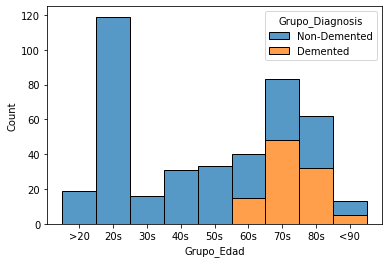

In [25]:
#Proporcion de sujetos según grado de demencia
sns.histplot(data=dementiaData2, x="Grupo_Edad",hue='Grupo_Diagnosis', multiple="stack")

Se observa que la cantidad de personas con diagnóstico de demencia en cualquiera de sus grados se encuentran en los grupos de 60 años en adelante. La edad resulta un factor que puede influir en otras variables, como en las siguientes:

<AxesSubplot:xlabel='Grupo_Edad', ylabel='nWBV'>

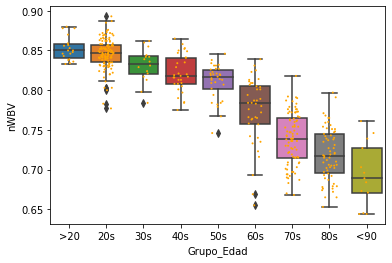

In [26]:
#Distribución del nWBV según grupo de edad
sns.boxplot( x=dementiaData2["Grupo_Edad"], y=dementiaData2["nWBV"])
sns.stripplot(x=dementiaData2["Grupo_Edad"], y=dementiaData2["nWBV"], data=dementiaData2, color="orange", jitter=0.2, size=2)

Se observa que a medida que se avanza en los grupos de edad, la mediana del volumen total del cerebro normalizado (nWBV) va disminuyendo, con un cambio más notorio a partir de los 60 años.

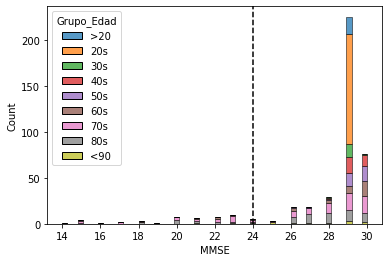

In [27]:
#Distribución del MMSE según grupo de edad
sns.histplot(data=dementiaData2, x="MMSE",hue='Grupo_Edad',multiple="stack")
plt.axvline(24, color='black', linestyle='--')

Las puntuaciones por debajo de 24 en el MMSE sugieren una función cognitiva anormal ligado a un posible diagnóstico de demencia, pudiendose observar en la gráfica que los grupos de edad que se encuentran debajo del puntaje, son los de 60s,70s, 80, <90.

### **Análisis solo en adultos mayores**

Tomando en cuenta la relevancia del factor edad, exploraremos más sobre la demencia en los sujetos
mayores de 60 años (n=198).

In [28]:
adultosMayores = dementiaData2.loc[(dementiaData2.Edad >= 60)]
len(adultosMayores)

198

In [29]:
adultosMayores["Grupo_Edad"] = pd.cut(adultosMayores.Edad,bins=[59, 69, 79, 89,99],labels=['60s', '70s', '80s', '<90'])

Text(0.5, 1.0, 'Proporcion de adultos mayores con demencia n=198')

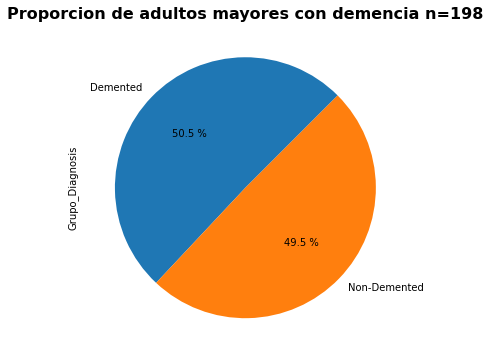

In [30]:
ax = adultosMayores.Grupo_Diagnosis.value_counts().plot.pie(startangle=45,
                                               autopct='%.1f %%',
                                               figsize=(8, 6))
ax.set_title("Proporcion de adultos mayores con demencia n=198",fontsize=16, weight="bold")

En la figura se observa que
el 50.5% (n=100) de los adultos presentan algún grado de
demencia.

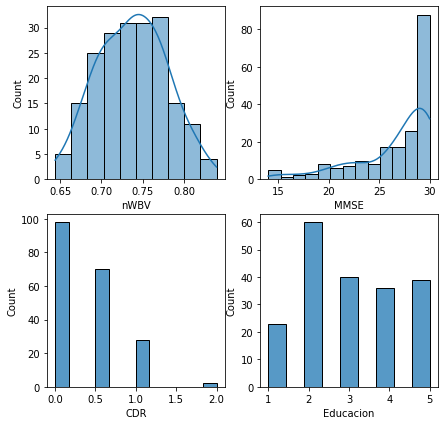

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
sns.histplot(data=adultosMayores, x="nWBV", kde=True, ax=axs[0, 0])
sns.histplot(data=adultosMayores, x="MMSE", kde=True, ax=axs[0, 1])
sns.histplot(data=adultosMayores, x="CDR", ax=axs[1, 0])
sns.histplot(data=adultosMayores, x="Educacion", ax=axs[1, 1])
plt.show()

Se observa que el volumen total del cerebro normalizado sigue
una distribución aparentemente normal con una mediana de
0.74; en el test MMSE hay una proporción alta que puntúan
por encima de 24 en el test; respecto al CDR, de los que
presentan algún grado de demencia, se observan mayor
frecuencia en demencia muy leve (0.5); y en cuanto al grado
de educación, con mayor frecuencia los sujetos presentaron
secundaria completa (2) y universidad incompleta (3).

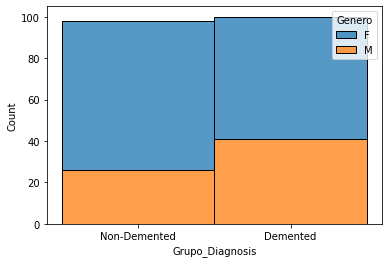

In [32]:
ax = sns.histplot(data=adultosMayores, x="Grupo_Diagnosis",hue='Genero',multiple="stack")

Se observa que tanto en el grupo con y sin
diagnóstico de demencia se observa una ligera mayoria del
sexo femenino.

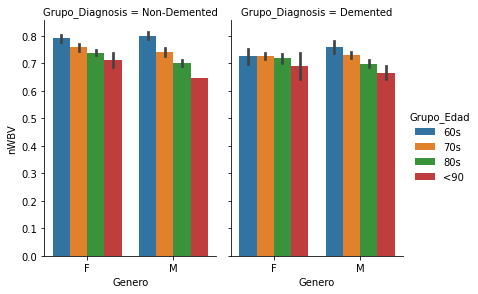

In [33]:
g = sns.catplot(x="Genero", y="nWBV",
                hue="Grupo_Edad", col="Grupo_Diagnosis",
                data=adultosMayores, kind="bar",
                height=4, aspect=.7)

Se observa que el volumen
total del cerebro normalizado, en el grupo con y sin demencia,
va disminuyendo mientras se avanza en los grupos de edad.

<AxesSubplot:xlabel='Grupo_Diagnosis', ylabel='Count'>

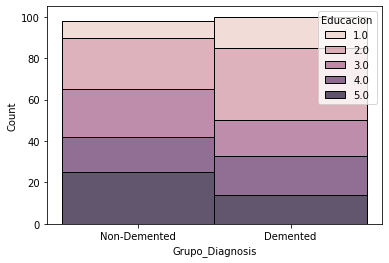

In [34]:
sns.histplot(data=adultosMayores, x="Grupo_Diagnosis",hue='Educacion',multiple="stack")

### **Análisis: comparación entre toda la población y solo en adultos mayores**

En el mapa de color con los valores de
los 416 sujetos en el dataset, y se puede observar que de las
variables de interés aquellas que presentan una mayor
correlación son: nWBV-Edad, nWBV-CDR, nWBV-MMSE,
CDR-Edad y CDR-MMSE. Se pensó que quizás la Educación
presentaría una mayor correlación con el test cognitivo
MMSE, pero solo se encontró una mayor relación con el
NSE.

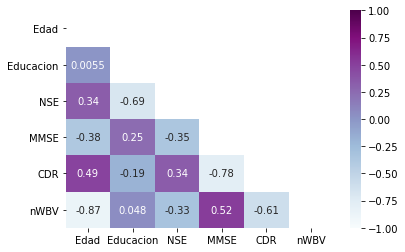

In [35]:
#Explorando correlaciones entre variables numericas en toda la población
from scipy import stats
num_corr= dementiaData2.corr()
# plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(num_corr, dtype=np.bool))
num_heatmap = sns.heatmap(num_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BuPu')
# num_heatmap.set_title('Correlacion - Mapa de Calor', fontdict={'fontsize':12}, pad=12);

Sin embargo, la fuerza de las correlaciones cambia cuando se
inserta solo valores de los adultos mayores (<60). En el siguiente mapa de calor se encuentra que las correlaciones entre las variables de
interés disminuyen en este grupo etario, las correlaciones
disminuyen en el siguiente orden descendente (mayor a menor
cambio): CDR-Edad, nWBV-Edad, nWBV-CDR, nWBV-
MMSE y CDR-MMSE.

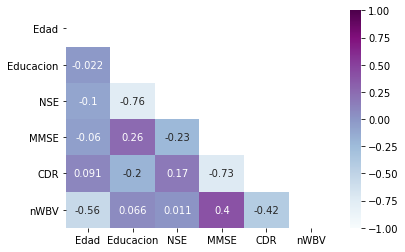

In [36]:
#Explorando correlaciones entre variables numericas solo en adultos mayores
from scipy import stats
num_corr= adultosMayores.corr()
# plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(num_corr, dtype=np.bool))
num_heatmap = sns.heatmap(num_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BuPu')

Text(0.5, 1.05, 'Correlación entre la Edad y nWBV en toda la población')

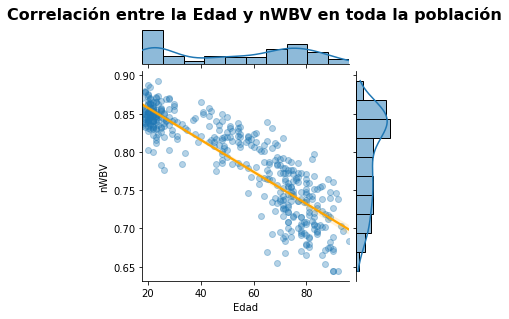

In [37]:
# Gráfico de dispersión entre Edad y nWBV en toda la población
g = sns.jointplot(x="Edad", y="nWBV",
                 data=dementiaData2, kind="reg",
                 line_kws={'color':'orange'},
                  scatter_kws={'alpha': 0.33},
                )
g.fig.set_size_inches(4, 4)
g.fig.suptitle("Correlación entre la Edad y nWBV en toda la población",
                fontsize=16, weight="bold", y=1.05)

Text(0.5, 1.05, 'Correlación entre la Edad y nWBV en adultos mayores de 60 años')

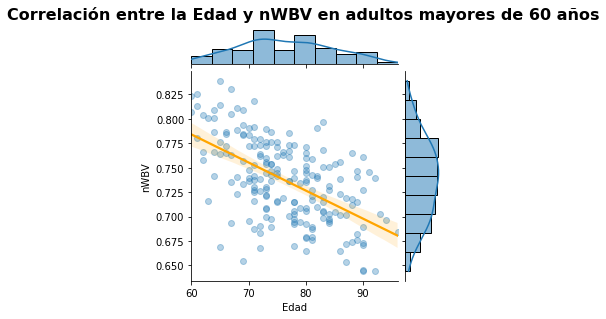

In [38]:
# Gráfico de dispersión entre Edad y nWBV en adultos mayores de 60 años
g = sns.jointplot(x="Edad", y="nWBV",
                 data=adultosMayores, kind="reg",
                 line_kws={'color':'orange'},
                  scatter_kws={'alpha': 0.33},
                )
g.fig.set_size_inches(4, 4)
g.fig.suptitle("Correlación entre la Edad y nWBV en adultos mayores de 60 años",
                fontsize=16, weight="bold", y=1.05)

La Edad y
el Volumen total del cerebro normalizado presentan una
correlación lineal muy alta (-0.87) y negativa en adultos entre
18-96 años, pero esta disminuye (-0.56) en el grupo de
adultos mayores, lo que podría indicar que la influencia de la
edad en el nWBV de este grupo etario disminuye.

In [39]:
dementiaData2["CDR"] = pd.cut(dementiaData2.CDR, bins=[-1, 0.4,0.6,1.5, 2],labels=['0', '0.5', '1', '2'])
adultosMayores["CDR"] = pd.cut(adultosMayores.CDR, bins=[-1, 0.4,0.6,1.5, 2],labels=['0', '0.5', '1', '2'])

<AxesSubplot:xlabel='nWBV', ylabel='Count'>

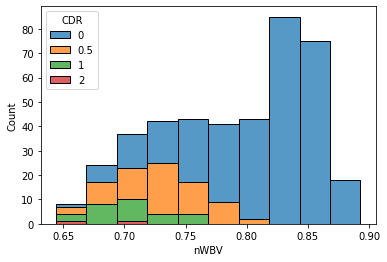

In [40]:
# Histograma de Edad según el CDR en toda la población
sns.histplot(data=dementiaData2, x="nWBV",hue='CDR',multiple="stack")

<AxesSubplot:xlabel='nWBV', ylabel='Count'>

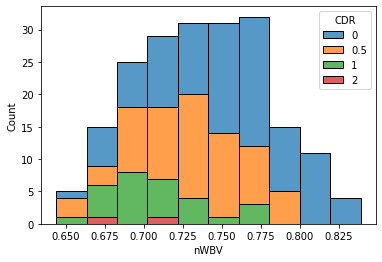

In [41]:
# Histograma de Edad según el CDR en adultos mayores de 60 años
sns.histplot(data=adultosMayores, x="nWBV",hue='CDR',multiple="stack")

Se puede observar que en la primera gráfica,
con los sujetos entre 18-96 años, la distribución del grado de
demencia “Sin demencia (0)” está más presente en
porcentajes altos del nWBV y los demás en porcentajes más
bajos. Pero en la segunda gráfica, con solo adultos mayores,
la tendencia se hace menos notoria, indicando que en este
grupo etario, las probabilidades de presentar algún grado de
demencia solo según el nWBV son muy difusas.

Text(0.5, 1.05, 'Correlación entre MMSE y nWBV en toda la población')

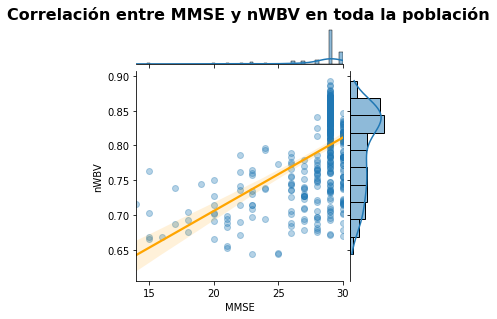

In [42]:
# Gráfico de dispersión entre MMSE y nWBV en toda la población
g = sns.jointplot(x="MMSE", y="nWBV",
                 data=dementiaData2, kind="reg",
                 line_kws={'color':'orange'},
                 scatter_kws={'alpha': 0.33})
g.fig.set_size_inches(4, 4)
g.fig.suptitle("Correlación entre MMSE y nWBV en toda la población",
                   fontsize=16, weight="bold", y=1.05)

Text(0.5, 1.05, 'Correlación entre MMSE y nWBV en adultos mayores de 60 años')

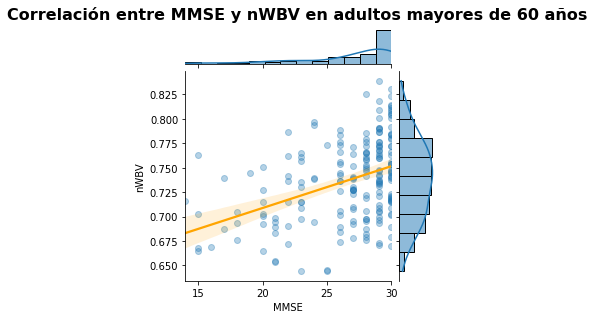

In [43]:
# Gráfico de dispersión entre MMSE y nWBV en adultos mayores de 60 años
g = sns.jointplot(x="MMSE", y="nWBV",
                 data=adultosMayores, kind="reg",
                 line_kws={'color':'orange'},
                 scatter_kws={'alpha': 0.33})
g.fig.set_size_inches(4, 4)
g.fig.suptitle("Correlación entre MMSE y nWBV en adultos mayores de 60 años",
                   fontsize=16, weight="bold", y=1.05)

Se puede ver en los gráficos anteriores que, a medida que el volumen total del cerebro
normalizado disminuye el rendimiento en el test cognitivo
MMSE también lo hace. La correlación es lineal, moderada y
positiva (0.52) en adultos entre 18-96 años, pero disminuye
en los adultos mayores de 60 años (0.40). En ambos gráficos de dispersión, los puntajes del MMSE
no se ajustan fuertemente a la tendencia lineal en función del
nWBV.

La relación se hace cada vez menor si se analiza la relación
entre la edad y los distintos grados de demencia, pero sigue
siendo una relación positiva. Como se ve en los siguientes graficos:

<AxesSubplot:xlabel='Edad', ylabel='Count'>

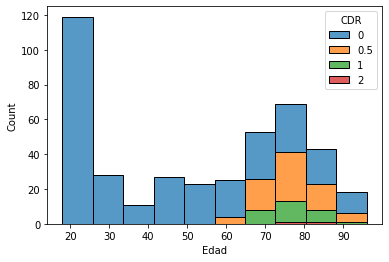

In [44]:
# Histograma de Edad segun el CDR en toda la población
sns.histplot(data=dementiaData2, x="Edad",hue='CDR',multiple="stack")

<AxesSubplot:xlabel='Edad', ylabel='Count'>

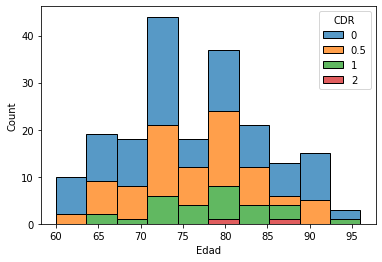

In [45]:
# Histograma de Edad segun el CDR en adultos mayores de 60 años
sns.histplot(data=adultosMayores, x="Edad",hue='CDR',multiple="stack")

La correlación es moderada
(0.49) en adultos entre 18-96 años, pero en los adultos
mayores la correlación cambia notoriamente, obteniendo una
correlación muy baja (0.091). A diferencia de la distribución de arriba, en los adultos
mayores se puede ver que los distintos grados de demencia
no siguen una tendencia muy clara según la edad, indicando
que en este grupo etario, las probabilidades de presentar algún
grado de demencia solo por la Edad son muy difusas.

## **Conclusión**

En el análisis exploratorio, se pudo encontrar las siguientes variables asociadas a la demencia: volumen total del cerebro, edad, rendimiento en el test cognitivo MMSE y el grado de demencia CDR, no se encontraron diferencias notables en cuanto género o grado educativo. Además se encontró que las correlaciones disminuyen si las variables son analizadas en población adulta mayor.